# Benchmarking more featurizations and ML methods in predicting formation enthalpies of compounds on OQMD dataset 

In this notebook, we'll compare performance of both featurizations and ML algorithms in [Ward (2016)](https://www.nature.com/articles/npjcompumats201628), [Ward (2017)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.96.024104), [Deml (2016)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.93.085142), [Faber (2016)](https://arxiv.org/abs/1503.07406) and [Schutt (2014)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.205118) in predicting formation enthalpies of compounds, $\Delta H_f$.

Note: Run `01.ipynb`, `featurize_ward2016_dataset.ipynb` and `featurize_deml_dataset.ipynb` before this notebook!!

In [1]:
import os
import numpy as np
import pandas as pd
import pymatgen as pmg
import matplotlib.pyplot as plt
import pickle
import time

from matminer.featurizers.structure import SineCoulombMatrix
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.utils.conversions import str_to_composition

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Lars

Import OQMD_ICSD data

In [3]:
cv_test_deml = pickle.load(open('./04_data/cv_test_deml.pkl', 'rb'))
cv_test_faber = pickle.load(open('./04_data/cv_test_faber.pkl', 'rb'))
cv_test_schutt = pickle.load(open('./04_data/cv_test_schutt.pkl', 'rb'))
cv_test_ward2016 = pickle.load(open('./04_data/cv_test_ward2016.pkl', 'rb'))
cv_test_ward2017 = pickle.load(open('./04_data/cv_test_ward2017.pkl', 'rb'))

y_test_deml = pickle.load(open('./04_data/y_test_deml.pkl', 'rb'))
y_test_faber = pickle.load(open('./04_data/y_test_faber.pkl', 'rb'))
y_test_schutt = pickle.load(open('./04_data/y_test_schutt.pkl', 'rb'))
y_test_ward2016 = pickle.load(open('./04_data/y_test_ward2016.pkl', 'rb'))
y_test_ward2017 = pickle.load(open('./04_data/y_test_ward2017.pkl', 'rb'))

cv_test = {'deml': cv_test_deml,
           'faber': cv_test_faber, 
           'schutt': cv_test_schutt, 
           'ward2016': cv_test_ward2016, 
           'ward2017': cv_test_ward2017}
y_test = {'deml': y_test_deml,
            'faber': y_test_faber, 
            'schutt': y_test_schutt, 
            'ward2016': y_test_ward2016, 
            'ward2017': y_test_ward2017}

In [ ]:
y = pd.read_pickle('./y.pkl')

In [ ]:
print ("Length of data: ", y.shape)

Initialize dictionary to store cv prediction data

In [2]:
kernels = ['ward2016', 'ward2017', 'deml', 'faber', 'schutt']
cv_test = dict.fromkeys(kernels)
x_train, x_test, y_train, y_test = dict.fromkeys(kernels), dict.fromkeys(kernels), dict.fromkeys(kernels), dict.fromkeys(kernels)

## 1) Faber et al (2016)
Kernel Ridge Regression (KRR) on Sine Coulomb Matrix (SCM) featurization. Since we already have the Coulomb matrix featurized file saved in `01.ipynb`, we can directly load it here.

In [ ]:
%%time
X_faber = pickle.load(open("./X_cm.pkl", "rb"))

Partition into training and testing set (80% training and 20% testing)

In [ ]:
x_train['faber'], x_test['faber'], y_train['faber'], y_test['faber'] = train_test_split(X_faber, y, test_size=0.2, shuffle=True)

#### Build ML model (Kernel Ridge Regression)

In [ ]:
krr = KernelRidge()
params = {}
params['scm'] = [{'kernel' : ['rbf'], 'alpha' : [10**(-a) for a in range(2,6)],
    'gamma': [1/2.0/s/s for s in (20000,40000,80000,160000,320000)]},
    {'kernel' : ['laplacian'], 'alpha' : [10**(-a) for a in range(2,6)],
    'gamma' : [1.0/s for s in (20000,40000,80000,160000,320000)]}]

In [ ]:
hpsel = GridSearchCV(krr, params['scm'], cv=KFold(5), refit=True)

Train KRR model using training set data

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hpsel.fit(x_train['faber'], y_train['faber'])

Assign best hyperparameters to model

In [ ]:
faber = hpsel.best_estimator_

Prediction data

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_test['faber'] = cross_val_predict(faber, x_test['faber'], y_test['faber'], cv=KFold(n_splits=5))

## 2) Ward et al (2016)  
RandomForestRegressor on "general purpose" attributes  

In [ ]:
df_ward2016 = pd.read_pickle("./ward2016_featurized_data.pkl")

Splitting dataset into training and testing dataset 

In [ ]:
X_ward2016 = df_ward2016.drop(['index', 'band_gap', 'delta_e', 'magnetic_moment', 'path', 'stability',
       'structure', 'total_energy', 'volume_pa', 'structure_obj',
       'composition', 'is_ICSD', 'composition_obj'], 1)
y_ward2016 = df_ward2016['delta_e']

In [ ]:
x_train['ward2016'], x_test['ward2016'], y_train['ward2016'], y_test['ward2016'] = train_test_split(X_ward2016, y_ward2016, test_size=0.2, shuffle=True)

#### Build ML model (Random Forest Regressor)

In [ ]:
param = dict(max_features=(np.linspace(0.1, 1, 10)).tolist())
ward2016 = GridSearchCV(RandomForestRegressor(n_estimators=100),
                        param_grid=param,
                        scoring='neg_mean_squared_error',
                        cv=KFold(5))

Fit using training set

In [ ]:
%%time
ward2016 = ward2016.fit(x_train['ward2016'], y_train['ward2016'])

Save the best model

In [ ]:
ward2016 = ward2016.best_estimator_

Predict testing data using model

In [ ]:
cv_test['ward2016'] = cross_val_predict(ward2016, x_test['ward2016'], y_test['ward2016'], cv=KFold(n_splits=5))

## 3) Ward et al (2017)

Random Forest Regressor on Voronoi-tessellation-based crystal representation.

Since the featurization takes a long time, we import the featurized pickle file ready for processing

In [ ]:
X_ward2017 = pd.read_pickle('./X_ward.pkl')

Splitting dataset into training and testing data

In [ ]:
x_train['ward2017'], x_test['ward2017'], y_train['ward2017'], y_test['ward2017'] = train_test_split(X_ward2017, y, test_size=0.2, shuffle=True)

#### Build ML model (Random Forest Regressor) 

In [ ]:
ward2017 = Pipeline([
    ('imputer', Imputer()), # For the failed structures
    ('model', RandomForestRegressor(n_estimators=100, n_jobs=-1))
])

In [ ]:
%%time 
ward2017 = ward2017.fit(x_train['ward2017'], y_train['ward2017'])

In [ ]:
cv_test['ward2017'] = cross_val_predict(ward2017, x_test['ward2017'], y_test['ward2017'], cv=KFold(n_splits=5))

## 4) Deml et al
Stepwise linear regression on composition featurized data. Since featurized data is already saved from running `featurize_deml_dataset.ipynb`, we can load data directly from that. 

In [ ]:
df_deml = pd.read_pickle('./deml_featurized_data.pkl')

Remove outliers

In [ ]:
original_count = len(df_deml)
df_deml = df_deml[np.logical_and(df_deml['delta_e'] >= -20, df_deml['delta_e'] <= 5)].reset_index(drop=True)
print('Removed %d/%d entries'%(original_count - len(df_deml), original_count))

Fill NaN with zero values

In [ ]:
df_deml.fillna(value=0, inplace=True)

In [ ]:
X_deml = df_deml.drop(['oxidation_states', 'total_energy', 'delta_e', 'composition', 'composition_obj'], 1)
y_deml = df_deml['delta_e']

Partition data into training and testing set

In [ ]:
x_train['deml'], x_test['deml'], y_train['deml'], y_test['deml'] = train_test_split(X_deml, y_deml, test_size=0.2, shuffle=Tru

#### Build ML model (Stepwise Linear Regression)

In [ ]:
deml = GridSearchCV(Lars(), 
                    param_grid=dict(n_nonzero_coefs=(range(10, X_deml.shape[1], 20).tolist())),
                    cv=KFold(5))

In [ ]:
deml = deml.fit(x_train['deml'], y_train['deml'])

Save the best model

In [ ]:
deml = deml.best_estimator_

Predict testing data

In [ ]:
cv_test['deml'] = cross_val_predict(deml, x_test['deml'], y_test['deml'], cv=KFold(5))

## 5) Schutt et al
Kernel Ridge Regression on Partial Radial Distribution Function (PRDF) representation.

In [ ]:
X_schutt = pd.read_pickle("./X_prdf.pkl")

Partition data into training and testing set

In [ ]:
x_train['schutt'], x_test['schutt'], y_train['schutt'], y_test['schutt'] = train_test_split(X_schutt, y, test_size=0.2, shuffle=Tru

#### Build ML model (Kernel Ridge Regression)

In [ ]:
schutt = KernelRidge(kernel='laplacian', alpha=0.001, gamma=5e-5)

In [ ]:
schutt = schutt.fit(x_train['schutt'], y_train['schutt'])

Predict testing data

In [ ]:
cv_test['schutt'] = cross_val_predict(schutt, x_test['schutt'], y_test['schutt'], cv=KFold(5))

## Now we compare these three models 

In [4]:
stats = dict.fromkeys(kernels)
for kernel in stats:
    stats[kernel] = dict.fromkeys(['r2_score', 'mean_absolute_error', 'mean_squared_error'], 0.0)

In [5]:
for kernel in kernels:
    for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
        stats[kernel][scorer] = (getattr(metrics,scorer)(y_test[kernel], cv_test[kernel]))

Plot predictions

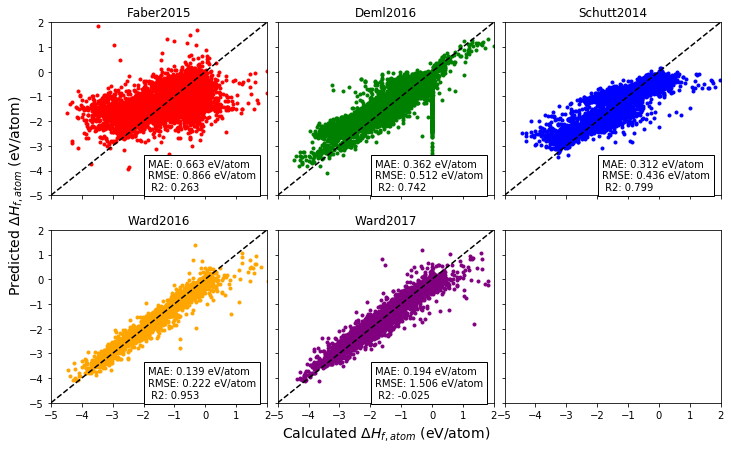

In [6]:
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

ax[0,0].set_xlim([-5, 2])
ax[0,0].set_ylim([-5, 2])

ax[0,0].set_ylabel("Predicted $\Delta H_{f, atom}$ (eV/atom)", fontsize=14, y=0.0)
ax[1,1].set_xlabel("Calculated $\Delta H_{f, atom}$ (eV/atom)", fontsize=14)

ax[0,0].set_title("Faber2015")
ax[0,1].set_title("Deml2016")
ax[0,2].set_title("Schutt2014")
ax[1,0].set_title("Ward2016")
ax[1,1].set_title("Ward2017")

ax[0,0].scatter(y_test['faber'], cv_test['faber'], marker='.', color='r')
ax[0,1].scatter(y_test['deml'], cv_test['deml'], marker='.', color='g')
ax[0,2].scatter(y_test['schutt'], cv_test['schutt'], marker='.', color='b')
ax[1,0].scatter(y_test['ward2016'], cv_test['ward2016'], marker='.', color='orange')
ax[1,1].scatter(y_test['ward2017'], cv_test['ward2017'], marker='.', color='purple')

for i in range(2):
    for j in range(3):
        if (i==1 and j==2):
            pass
        else:
            ax[i,j].plot(ax[i,j].get_xlim(), ax[i,j].get_xlim(), 'k--')

ax[0,0].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['faber']['mean_absolute_error'], np.sqrt(stats['faber']['mean_squared_error']), stats['faber']['r2_score']),
        transform=ax[0,0].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax[0,1].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['deml']['mean_absolute_error'], np.sqrt(stats['deml']['mean_squared_error']), stats['deml']['r2_score']),
        transform=ax[0,1].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax[0,2].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['schutt']['mean_absolute_error'], np.sqrt(stats['schutt']['mean_squared_error']), stats['schutt']['r2_score']),
        transform=ax[0,2].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax[1,0].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['ward2016']['mean_absolute_error'], np.sqrt(stats['ward2016']['mean_squared_error']), stats['ward2016']['r2_score']),
        transform=ax[1,0].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax[1,1].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['ward2017']['mean_absolute_error'], np.sqrt(stats['ward2017']['mean_squared_error']), stats['ward2017']['r2_score']),
        transform=ax[1,1].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})

fig.set_size_inches((12, 7))
fig.subplots_adjust(wspace=0.05)